# LSTM regression 重寫，改用book的範例來寫

In [1]:
#tensorflow 2.8要搭keras 2.6 (雖然很奇怪，但就這樣…)
# https://stackoverflow.com/questions/72255562/cannot-import-name-dtensor-from-tensorflow-compat-v2-experimental
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

2.8.0
2.6.0


In [2]:
# !pip install cryptography

In [2]:
#測試隨機性是否可以控制下來，以免學習結果一直變化難以judge (https://kknews.cc/tech/68r4jqm.html)
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
#ignore tensorflow warning:
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)





import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
pd.options.display.float_format = '{:.2f}'.format
import time,ccxt,os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #3是全都不顯示

from datetime import datetime,timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# import talib as ta
from talib import abstract as ab

#get last price
import requests
import json

import pymysql 

# machine learning:
# from sklearn.ensemble import RandomForestClassifier
import pickle

#平均數
from scipy.stats import gmean
from scipy.stats import hmean

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,LSTM,TimeDistributed,GRU
from tensorflow.keras import regularizers
from keras import Input
from keras.layers import Bidirectional, RepeatVector

#for RMSE:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('dark_background') #使用暗背景




def read_from_mysql(tablename):
    conn = pymysql.connect(host='192.168.68.122',user='testuser',passwd='test1234',db='testuser',charset='utf8')


    sql="select * from "
    sql=sql +tablename 
    

    df= pd.read_sql(sql, conn)
    conn.close()

    return df





    
def handle_data(df,fast,slow,factor_out):
    # 把string改成float，以利後續計算：
    df['open']=df['price_open'].astype(float)
    df['high']=df['price_high'].astype(float)
    df['low']=df['price_low'].astype(float)
    df['close']=df['price_close'].astype(float)
    df['volume']=df['volume'].astype(float)

    #---------集中drop 區-----------------------------------------------------
    df['EMA_fast'] = ab.EMA(df,timeperiod=fast)
    df['EMA_slow'] = ab.EMA(df,timeperiod=slow)
    # df.dropna(inplace=True)

    df['ATR'] = ab.ATR(df,timeperiod=fast)
    df['HH']=df['close'].rolling(fast).max()
    df.dropna(inplace=True)

    #---------EMA--------------------------------------------------------------
    # df['EMA_fast'] = ab.EMA(df,timeperiod=fast)
    # df['EMA_slow'] = ab.EMA(df,timeperiod=slow)
    # df.dropna(inplace=True) #集中
    
    df['EMA_diff_fast']=(df['close']-df['EMA_fast'])/df['EMA_fast'] 
    df['EMA_diff_slow']=(df['EMA_fast']-df['EMA_slow'])/df['EMA_slow'] 
    df['EMA_diff_product']=df['EMA_diff_fast']*df['EMA_diff_slow'] 
    
    #---------Chandelier------------------------------
    # df['ATR'] = ab.ATR(df,timeperiod=fast)
    # df['HH']=df['close'].rolling(fast).max()
    # df.dropna(inplace=True) #集中

    df['Chandelier_bull_rank']=(df['close']-(df['HH']-factor_out*df['ATR'])).apply(lambda x:1 if x>0 else 0) #1 表示收盤價在吊燈上方，繼續持有
    df['Chandelier_bull_rank_exit']=(df['close']-(df['HH']-0.81*factor_out*df['ATR'])).apply(lambda x:1 if x>0 else 0) #3/5 test ATR*0.81



    #--------LSTM不需要時間欄，把多餘的欄位刪掉 -------------------------------------
    df.drop(['open_time','human_time','price_open','price_high','price_low','price_close'],axis=1,inplace=True)
    


    df.dropna(inplace=True)



    return df





# 改用keras book的example，這個可以改的參數比較多(擴充性佳)

In [3]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][4] #close在第5欄 
        yield samples, targets

In [4]:
#讀取資料：
########## parameters #########################################################
fast=13
slow=55
factor_out=3


# shift_cnt=1
candle_interval='1h'
################################################################################
#讀取資料：
symbol='TRX/USDT'
df=read_from_mysql(symbol.replace('/','_')+"_"+candle_interval)
# df=df.iloc[-30000:,:] #只取近期的, 共47111筆
###################################### handle data ###########################################################

df=handle_data(df,fast,slow,factor_out)
print(df.shape)
df.head()


(50749, 14)


,volume,open,high,low,close,EMA_fast,EMA_slow,ATR,HH,EMA_diff_fast,EMA_diff_slow,EMA_diff_product,Chandelier_bull_rank,Chandelier_bull_rank_exit
54,24225300.60,0.04,0.04,0.04,0.04,0.04,0.04,0.00,0.04,-0.01,-0.08,0.00,1,1
55,32193341.10,0.04,0.04,0.04,0.04,0.04,0.04,0.00,0.04,0.00,-0.08,-0.00,1,1
56,28609639.30,0.04,0.04,0.04,0.04,0.04,0.04,0.00,0.04,-0.02,-0.08,0.00,1,1
57,21653332.40,0.04,0.04,0.04,0.04,0.04,0.04,0.00,0.04,-0.01,-0.08,0.00,1,1
58,12694370.00,0.04,0.04,0.04,0.04,0.04,0.04,0.00,0.04,-0.01,-0.08,0.00,1,1


In [22]:
# #dataframe to array: (用下面那個方法轉成array)
# float_data=df.values
# print(float_data.shape)
# print(float_data[0])

(50005, 14)
[ 2.42253006e+07  3.95100000e-02  4.05000000e-02  3.88000000e-02
  4.04000000e-02  4.09171505e-02  4.46316364e-02  1.32777756e-03
  4.33300000e-02 -1.26389661e-02 -8.32254022e-02  1.05188303e-03
  1.00000000e+00  1.00000000e+00]


In [5]:
#another dataframe to array (https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array)
#stackoverflow說這個方法比較好，但上一個用values就可以用了，不確定好在哪裡？

float_data=df.to_numpy(dtype='float',na_value=np.nan)
print(float_data.shape)
print(float_data[0])

(50749, 14)
[ 2.42253006e+07  3.95100000e-02  4.05000000e-02  3.88000000e-02
  4.04000000e-02  4.09171505e-02  4.46316364e-02  1.32777756e-03
  4.33300000e-02 -1.26389661e-02 -8.32254022e-02  1.05188303e-03
  1.00000000e+00  1.00000000e+00]


In [6]:
#normalize:
sc = MinMaxScaler(feature_range=(0, 1))
float_data = sc.fit_transform(float_data)
print(float_data[0])

[0.00812804 0.19176273 0.1849255  0.19336883 0.19697606 0.19880218
 0.2333525  0.15495497 0.20448469 0.42734907 0.35494306 0.23207544
 1.         1.        ]


In [7]:
lookback = 96 #1440
step = 1 #6
delay = 24 #144
batch_size = 128 #原128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=40000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=40001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)


# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (len(float_data) - 40001 - lookback) // batch_size



In [8]:
#LSTM:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='tanh', #relu
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #原500
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/3
100/100 [==============================] - 86s 824ms/step - loss: 0.0514 - val_loss: 0.4543
Epoch 2/3
100/100 [==============================] - 83s 831ms/step - loss: 0.0320 - val_loss: 0.0716
Epoch 3/3
100/100 [==============================] - 81s 811ms/step - loss: 0.0333 - val_loss: 0.1200


In [34]:
#predict and reverse:
yhat = model.predict(val_gen)


KeyboardInterrupt: 

In [ ]:
print(len(yhat))

In [ ]:
print(yhat[-1])

In [ ]:
real_y=sc.inverse_transform(yhat[-1])
print(real_y)

# 書上的範例先搞清楚：

In [42]:
import os
f=open('jena_climate_2009_2016.csv')
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))



['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [43]:
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i , line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]] #不放入日期記錄到陣列中
    float_data[i,:]=values

print(float_data.shape)


(420451, 14)


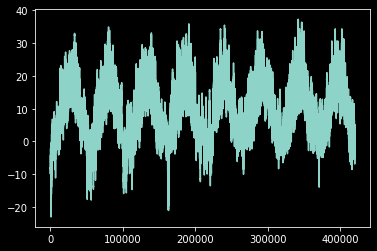

In [44]:
from matplotlib import pyplot as plt
temp=float_data[:,1] #索引1為溫度資料
plt.plot(range(len(temp)),temp)


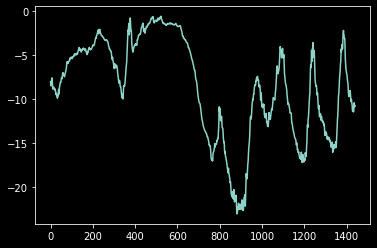

In [45]:
plt.plot(range(1440),temp[:1440]) #前10天共1440筆資料點(10分鐘記錄一筆)

In [46]:
#標準化資料 (只使用前20000筆來訓練)
mean=float_data[:200000].mean(axis=0)
float_data-=mean
std=float_data[:200000].std(axis=0)
float_data/=std


In [47]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] #溫度在第2欄 
        yield samples, targets

In [48]:
lookback = 1440 
step = 6
delay = 144
batch_size = 128 

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)


# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (len(float_data) - 40001 - lookback) // batch_size


In [40]:
val_gen

<generator object generator at 0x000001C3E1520C10>

In [49]:
#LSTM:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='tanh', #relu
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #原500
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/3
100/100 [==============================] - 714s 7s/step - loss: 0.3086 - val_loss: 0.4022
Epoch 2/3
100/100 [==============================] - 706s 7s/step - loss: 0.3131 - val_loss: 0.4926
Epoch 3/3
100/100 [==============================] - 711s 7s/step - loss: 0.2973 - val_loss: 0.7336
